# MONTHLY COMMODITY FUTURES INDEX

## Imports

In [6]:
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sbn
import numpy             as np

from warnings                      import filterwarnings
from helpers                       import HarModel, HarchModel
from itertools                     import product
from pandas.tools.plotting         import autocorrelation_plot
from scipy.stats                   import expon, laplace, t
from arch.univariate               import HARX, HARCH, GARCH, EGARCH, StudentsT, SkewStudent
from statsmodels.graphics.tsaplots import plot_pacf

## Notebook  Settings

In [7]:
filterwarnings('ignore')
%matplotlib notebook
sbn.set_style('whitegrid')

## Read and Fix Data

In [8]:
dat_file = './data/CommodityIndices.xlsx'
skiprows = (2, 3, 4, 5)
raw_data = pd.read_excel(dat_file, skiprows=skiprows, index_col=0, parse_cols='B:AE')

raw_data.columns = [column[4:-2].rstrip() for column in raw_data.columns]
raw_data.iloc[0] = 100.0

## Single Index Analysis

### Pick any one by name

In [9]:
raw_data.columns.values.tolist()

['Commodity',
 'Energy',
 'Precious Metals',
 'Industrial Metals',
 'Agriculture',
 'Livestock',
 'WTI Crude Oil',
 'Brent Crude',
 'Heat Oil',
 'Unleaded Gas',
 'Natural Gas',
 'Aluminum',
 'Copper',
 'Nickel',
 'Zinc',
 'Gold',
 'Silver',
 'Wheat',
 'Kansas Wheat',
 'Corn',
 'Soybeans',
 'Soybean Oil',
 'Soybean Meal',
 'Cotton',
 'Sugar',
 'Coffee',
 'Cocoa',
 'Live Cattle',
 'Lean Hogs']

<IPython.core.display.Javascript object>


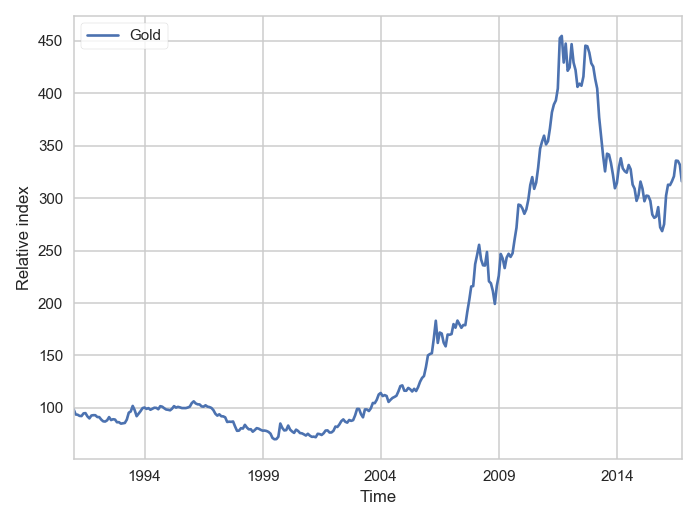

In [10]:
name = 'Gold' # Name of index as string

data = raw_data[name].resample('BM').mean()

fig, ax = plt.subplots(num=name+' Over the Aeons')
data.plot(ax=ax, label=name)

ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.8)
ax.set_xlabel('Time')
ax.set_ylabel('Relative index')

fig.tight_layout()

We don't want to do any smoothing or averaging to find a trend in the data because we know little of how to extrapolate such a trend to the future.

### Let's look at daily returns instead
**Note**: Log-returns would show pretty much the same picture but simple differences put a trend on the volatility.

<IPython.core.display.Javascript object>


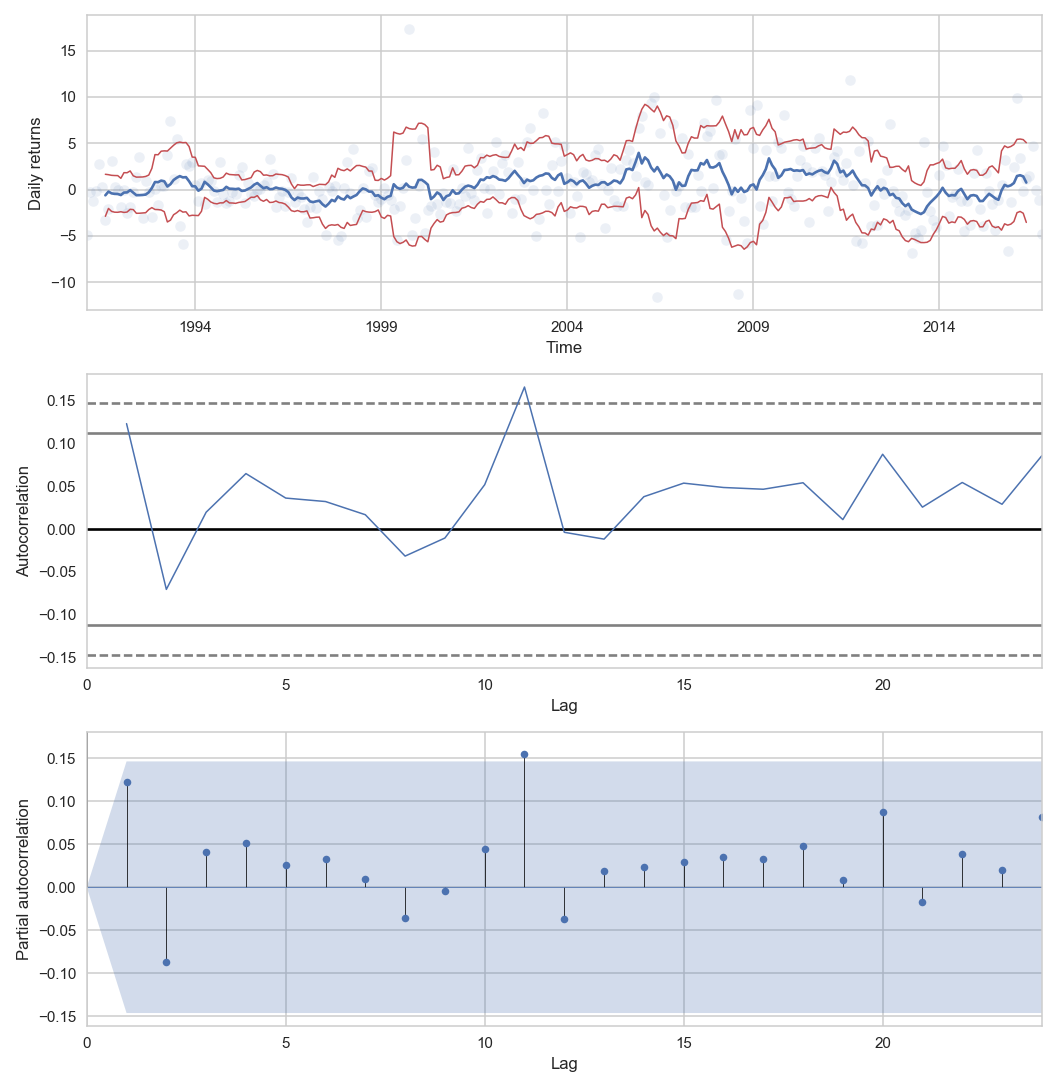

In [11]:
winsize = 12  # Window size (in business months) to average over
max_lag = 24  # Maximum lag to consider in (partial) autocorrelation

returns = 100 * data.pct_change(1).dropna()
rtnswin = returns.rolling(winsize, center=True) # or .ewm(com=winsize)
rtnmean = rtnswin.mean()
rtn_std = rtnswin.std()

fig = plt.figure(num='Returns on '+name+' and their (Partial) Autocorrelation', figsize=(9.7, 10))
return_ax = fig.add_subplot(311)
aucorr_ax = fig.add_subplot(312)
pacorr_ax = fig.add_subplot(313)

returns.plot(color='#4c72b0', style=['_'], marker='o', alpha=0.1, ax=return_ax)
rtnmean.plot(color='#4c72b0', ax=return_ax)
(rtnmean + rtn_std).plot(color='#c44e52', linewidth=1.0, ax=return_ax)
(rtnmean - rtn_std).plot(color='#c44e52', linewidth=1.0, ax=return_ax)
return_ax.set_xlabel('Time')
return_ax.set_ylabel('Daily returns')

autocorrelation_plot(returns, linewidth=1.0, ax=aucorr_ax)
aucorr_ax.set_xlim(left=0, right=max_lag)

plot_pacf(returns, lags=max_lag, alpha=0.01, ax=pacorr_ax, linewidth=0.5)
pacorr_ax.set_ylim(aucorr_ax.get_ylim())
pacorr_ax.set_xlim(aucorr_ax.get_xlim())
pacorr_ax.set_title('')
pacorr_ax.set_xlabel('Lag')
pacorr_ax.set_ylabel('Partial autocorrelation')

fig.tight_layout()

**We note that**:
2. The mean is fairly stable.
3. The variance is clearly not.
4. The (partial) autocorrelation of the returns is not particularly pronounced.

So let's look at the *absolute* returns and their autocorrelation next.

### Absolute returns and their autocorrelation

<IPython.core.display.Javascript object>


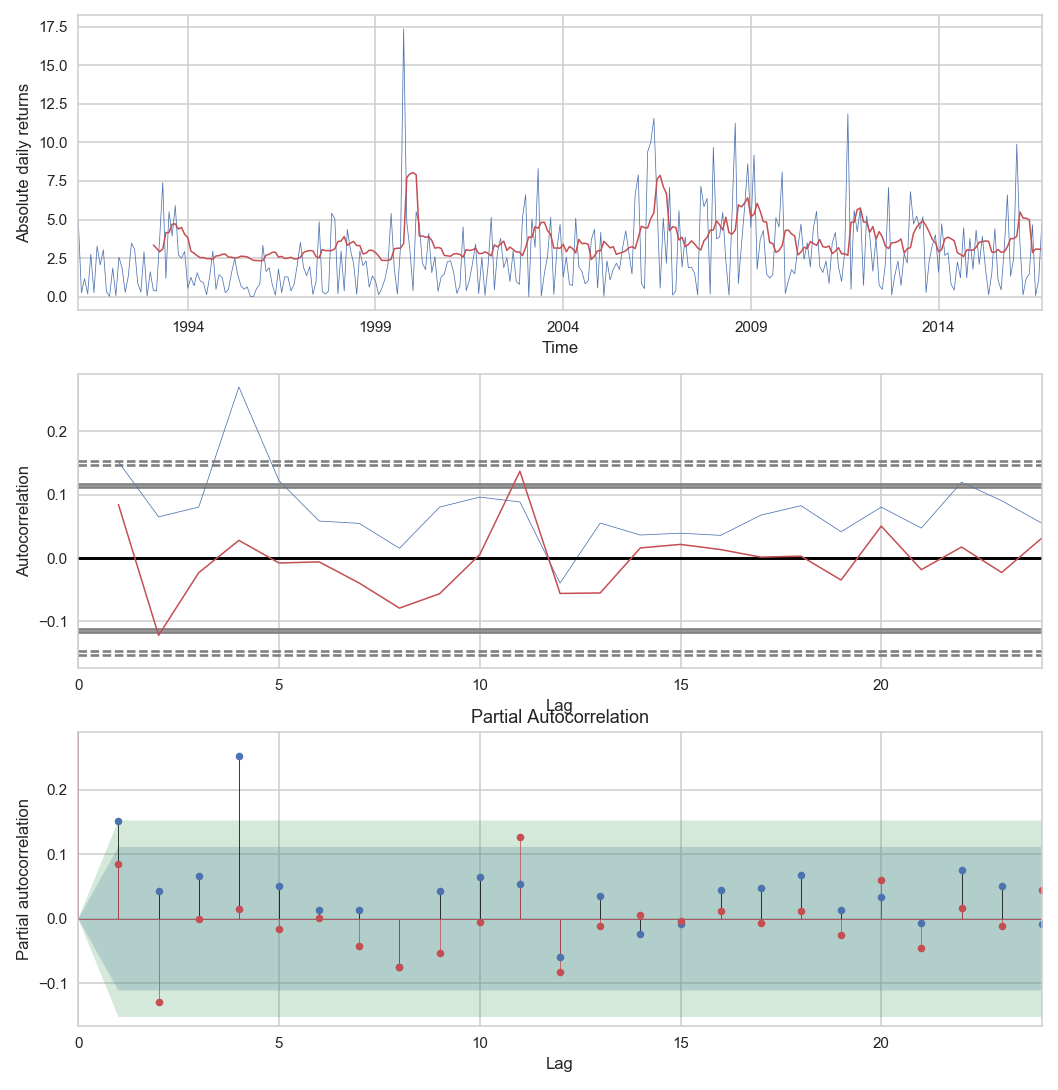

In [12]:
fig = plt.figure(num='Absolute Returns on '+name+' and their (Partial) Autocorrelation', figsize=(9.7, 10))
return_ax = fig.add_subplot(311)
aucorr_ax = fig.add_subplot(312)
pacorr_ax = fig.add_subplot(313)

returns.abs().plot(linewidth=0.5, ax=return_ax)
return_ax.set_xlabel('Time')
return_ax.set_ylabel('Absolute daily returns')

autocorrelation_plot(returns.abs(), linewidth=0.5, ax=aucorr_ax);
aucorr_ax.set_xlim(left=0, right=max_lag)

plot_pacf(returns.abs(), lags=max_lag, alpha=0.05, ax=pacorr_ax, linewidth=0.5)
pacorr_ax.set_ylim(aucorr_ax.get_ylim())
pacorr_ax.set_xlim(aucorr_ax.get_xlim())
pacorr_ax.set_title('')
pacorr_ax.set_xlabel('Lag')
pacorr_ax.set_ylabel('Partial autocorrelation')

fig.tight_layout()

We observe volatility bunching and long-term autocorrelation of the absolute returns. The  *partial* autocorrelation dies off at much shorter lags.

### Distribution of (absolute) returns 

<IPython.core.display.Javascript object>


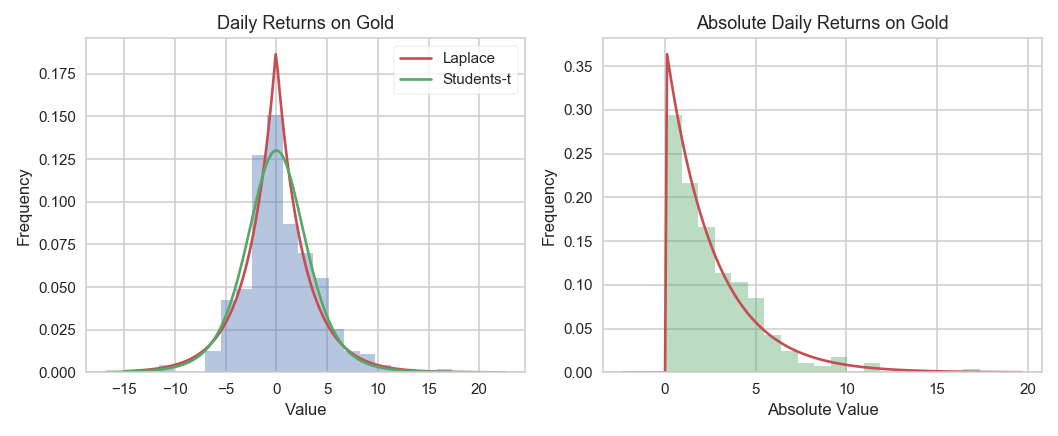

In [13]:
fig = plt.figure(num='Distribution of (Absolute) Returns on '+name, figsize=(9.7, 4))
returns_ax = fig.add_subplot(121)
absrtns_ax = fig.add_subplot(122)

sbn.distplot(returns, 
             bins=19, 
             kde=False, 
             fit=laplace, 
             fit_kws={'color': '#c44e52', 'label': 'Laplace'}, 
             ax=returns_ax);
returns_ax.set_title('Daily Returns on '+name)
returns_ax.set_xlabel('Value')
returns_ax.set_ylabel('Frequency')

sbn.distplot(returns.abs(), 
             bins=19, 
             kde=False, 
             fit=expon, 
             fit_kws={'color': '#c44e52'}, 
             color='#55a868', 
             ax=absrtns_ax); 
absrtns_ax.set_title('Absolute Daily Returns on '+name)
absrtns_ax.set_xlabel('Absolute Value')
absrtns_ax.set_ylabel('Frequency')

x_lims = returns_ax.get_xlim()
x_vals = np.linspace(*x_lims, 200)
params = t.fit(returns[returns.abs() > 0.05], floc=0)
returns_ax.plot(x_vals, t.pdf(x_vals, *params), label='Students-t')
returns_ax.legend(loc='best', frameon=True, fancybox=True, framealpha=0.8)

fig.tight_layout()

They returns follow a *Laplace*- whereas the absolute returns follow an *Exponential* (or maybe also a *Pareto*) distribution. The tails are *far* too fat for a Gaussian process. Interestingly, a *Students-t* distribution appears to be quite a reasonable fit for the returns, if the pronounced peak at zero is neglected.

### Fit a HAR+HARCH model

#### Initialize ar HAR model

In [14]:
params = {           'y': returns,
              'constant': False,
             'hold_back': max_lag,
          'distribution': StudentsT()}

har = HarModel(params)

#### Find optimal HAR model

In [15]:
while har.bic.gets_smaller():
    har.refine()
    har.extend()

result = har.model.fit()
result.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 763.4898278174451
Iteration:      2,   Func. Count:     12,   Neg. LLF: 763.4656965842048
Iteration:      3,   Func. Count:     17,   Neg. LLF: 763.3994980772259
Iteration:      4,   Func. Count:     22,   Neg. LLF: 763.3656323556303
Iteration:      5,   Func. Count:     27,   Neg. LLF: 763.3543920755277
Iteration:      6,   Func. Count:     32,   Neg. LLF: 763.339456120329
Iteration:      7,   Func. Count:     37,   Neg. LLF: 763.3393672601924
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 763.339366546
            Iterations: 7
            Function evaluations: 38
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                       HAR - Constant Variance Model Results                        
====================================================================================
Dep. Variable:                         Gold   R-squared:                       0.033
Mean Model:                             HAR   Adj. R-squared:                  0.033
Vol Model:                Constant Variance   Log-Likelihood:               -763.339
Distribution:      Standardized Student's t   AIC:                           1532.68
Method:                  Maximum Likelihood   BIC:                           1543.64
                                              No. Observations:                  285
Date:                      Tue, Feb 07 2017   Df Residuals:                      282
Time:                              11:19:37   Df Model:                            3
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Gold[0:24]     0.6492      0.229      2.840  4.510e-03       [  0.201,  1.097]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
sigma2        13.2938      1.739      7.645  2.092e-14       [  9.886, 16.702]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             5.6801      1.934      2.937  3.319e-03       [  1.889,  9.471]
==============================================================================

Covariance estimator: robust
"""

#### Add optimal HARCH volatility to the model

In [16]:
harch = HarchModel(har.model)

while harch.bic.gets_smaller():
    harch.refine()
    harch.extend()

result = harch.model.fit()
result.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 761.1793596029122
Iteration:      2,   Func. Count:     14,   Neg. LLF: 756.9110842964658
Iteration:      3,   Func. Count:     22,   Neg. LLF: 753.1056746846563
Iteration:      4,   Func. Count:     29,   Neg. LLF: 752.6507679292444
Iteration:      5,   Func. Count:     35,   Neg. LLF: 751.905496600277
Iteration:      6,   Func. Count:     41,   Neg. LLF: 751.781542993007
Iteration:      7,   Func. Count:     47,   Neg. LLF: 751.7257385594772
Iteration:      8,   Func. Count:     53,   Neg. LLF: 751.7234152161648
Iteration:      9,   Func. Count:     59,   Neg. LLF: 751.723267447871
Iteration:     10,   Func. Count:     65,   Neg. LLF: 751.7232349857181
Iteration:     11,   Func. Count:     71,   Neg. LLF: 751.7231599260324
Iteration:     12,   Func. Count:     77,   Neg. LLF: 751.723152088173
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 751.723151331
            Iterations: 12
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                             HAR - HARCH Model Results                              
====================================================================================
Dep. Variable:                         Gold   R-squared:                       0.033
Mean Model:                             HAR   Adj. R-squared:                  0.033
Vol Model:                            HARCH   Log-Likelihood:               -751.723
Distribution:      Standardized Student's t   AIC:                           1511.45
Method:                  Maximum Likelihood   BIC:                           1526.06
                                              No. Observations:                  285
Date:                      Tue, Feb 07 2017   Df Residuals:                      281
Time:                              11:19:42   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Gold[0:24]     0.6922      0.195      3.556  3.762e-04       [  0.311,  1.074]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          5.3749      1.519      3.538  4.035e-04       [  2.397,  8.353]
alpha[4]       0.6498      0.189      3.444  5.741e-04       [  0.280,  1.020]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             7.2207      3.171      2.277  2.277e-02       [  1.006, 13.435]
==============================================================================

Covariance estimator: robust
"""

#### Try if adding a constant to the mean model, allowing for skew of the Student's t-distribution, or a different volatility model reduces the BIC

In [17]:
fixed = {           'y': returns,
                 'lags': har.lags,
            'hold_back': max_lag}

tests = {    'constant': [False, True],
         'distribution': [StudentsT(), SkewStudent()],
           'volatility': [HARCH(lags=harch.lags),
                          GARCH(p=1, o=0, q=1),
                          GARCH(p=1, o=1, q=1), 
                          GARCH(p=1, o=0, q=1, power=1.0),
                          GARCH(p=1, o=1, q=1, power=1.0),
                         EGARCH(p=1, o=0, q=1),
                         EGARCH(p=1, o=1, q=1)]}

fit_kws = {'update_freq': 0,
                  'disp': 'off'}

params_grid = (dict(zip(tests.keys(), values)) for values in product(*tests.values()))

min_bic, min_params = min((HARX(**fixed, **params).fit(**fit_kws).bic, params) for params in params_grid)

print('Minimum BIC is: ', min_bic)
print('for model with: ', [str(param) for param in min_params.values()])

model = HARX(**fixed, **min_params)
result = model.fit(**fit_kws)
result.summary()

Minimum BIC is:  1526.05625938
for model with:  ['False', "Standardized Student's t distribution", 'HARCH(lags: 4)']


<class 'statsmodels.iolib.summary.Summary'>
"""
                             HAR - HARCH Model Results                              
====================================================================================
Dep. Variable:                         Gold   R-squared:                       0.033
Mean Model:                             HAR   Adj. R-squared:                  0.033
Vol Model:                            HARCH   Log-Likelihood:               -751.723
Distribution:      Standardized Student's t   AIC:                           1511.45
Method:                  Maximum Likelihood   BIC:                           1526.06
                                              No. Observations:                  285
Date:                      Tue, Feb 07 2017   Df Residuals:                      281
Time:                              11:19:49   Df Model:                            4
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Gold[0:24]     0.6922      0.195      3.556  3.762e-04       [  0.311,  1.074]
                               Volatility Model                               
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
omega          5.3749      1.519      3.538  4.035e-04       [  2.397,  8.353]
alpha[4]       0.6498      0.189      3.444  5.741e-04       [  0.280,  1.020]
                                 Distribution                                 
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
nu             7.2207      3.171      2.277  2.277e-02       [  1.006, 13.435]
==============================================================================

Covariance estimator: robust
"""

#### Plot residuals and analyze their (partial) autocorrelation

<IPython.core.display.Javascript object>


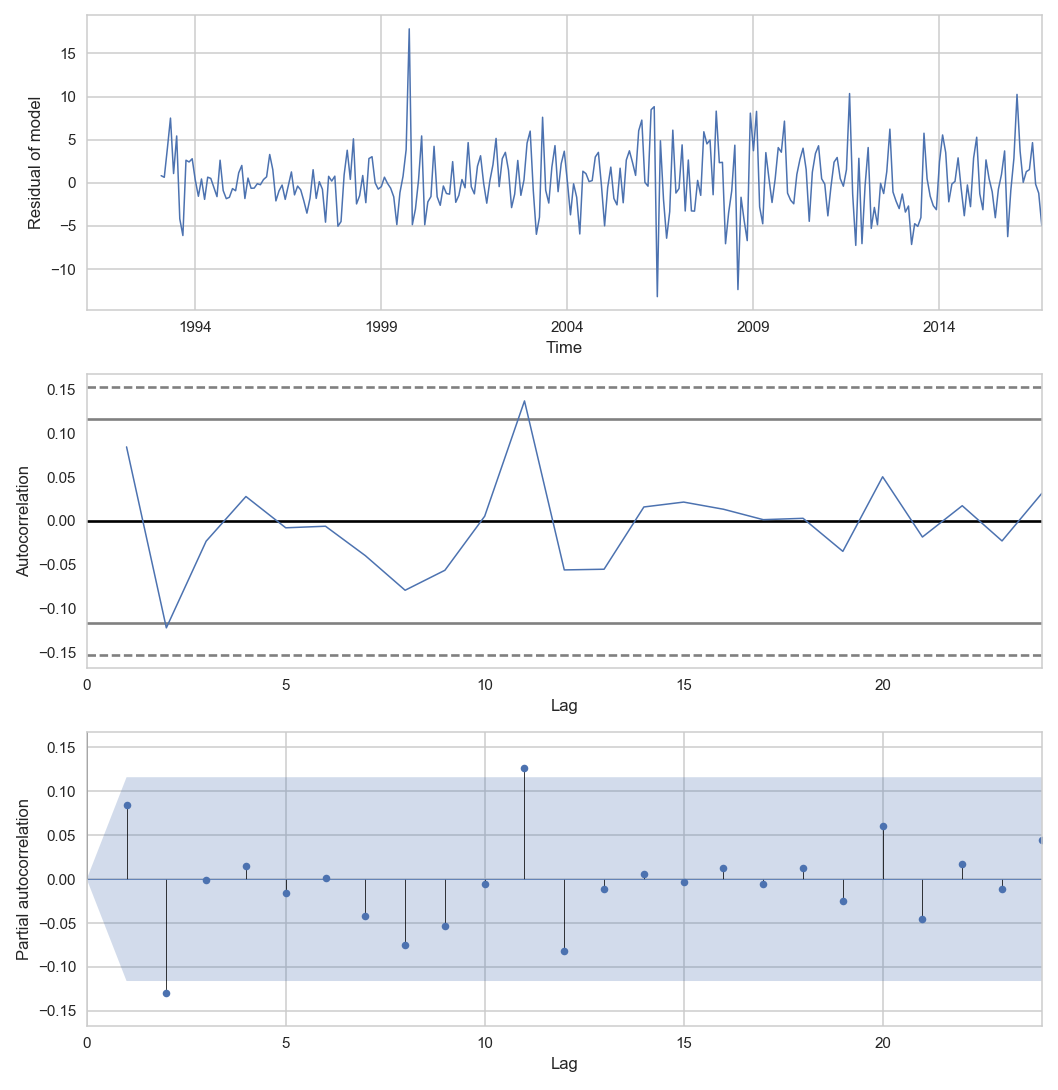

In [18]:
fig = plt.figure(num='Residuals of HAR+Volatility Model and their (Partial) Autocorrelation', figsize=(9.7, 10))
residual_ax = fig.add_subplot(311)
autocorr_ax = fig.add_subplot(312)
partcorr_ax = fig.add_subplot(313)

result.resid.plot(ax=residual_ax, linewidth=1)
residual_ax.set_xlabel('Time')
residual_ax.set_ylabel('Residual of model')

autocorrelation_plot(result.resid.dropna(), ax=autocorr_ax, linewidth=1)
autocorr_ax.set_xlim(left=0, right=max_lag)

plot_pacf(result.resid.dropna(), lags=max_lag, alpha=0.05, ax=partcorr_ax, linewidth=0.5)
partcorr_ax.set_ylim(autocorr_ax.get_ylim())
partcorr_ax.set_xlim(autocorr_ax.get_xlim())
partcorr_ax.set_title('')
partcorr_ax.set_xlabel('Lag')
partcorr_ax.set_ylabel('Partial autocorrelation')

fig.tight_layout()

#### Analyze fit to the conditional volatility and the suppression of its (partial) autocorrelation

<IPython.core.display.Javascript object>


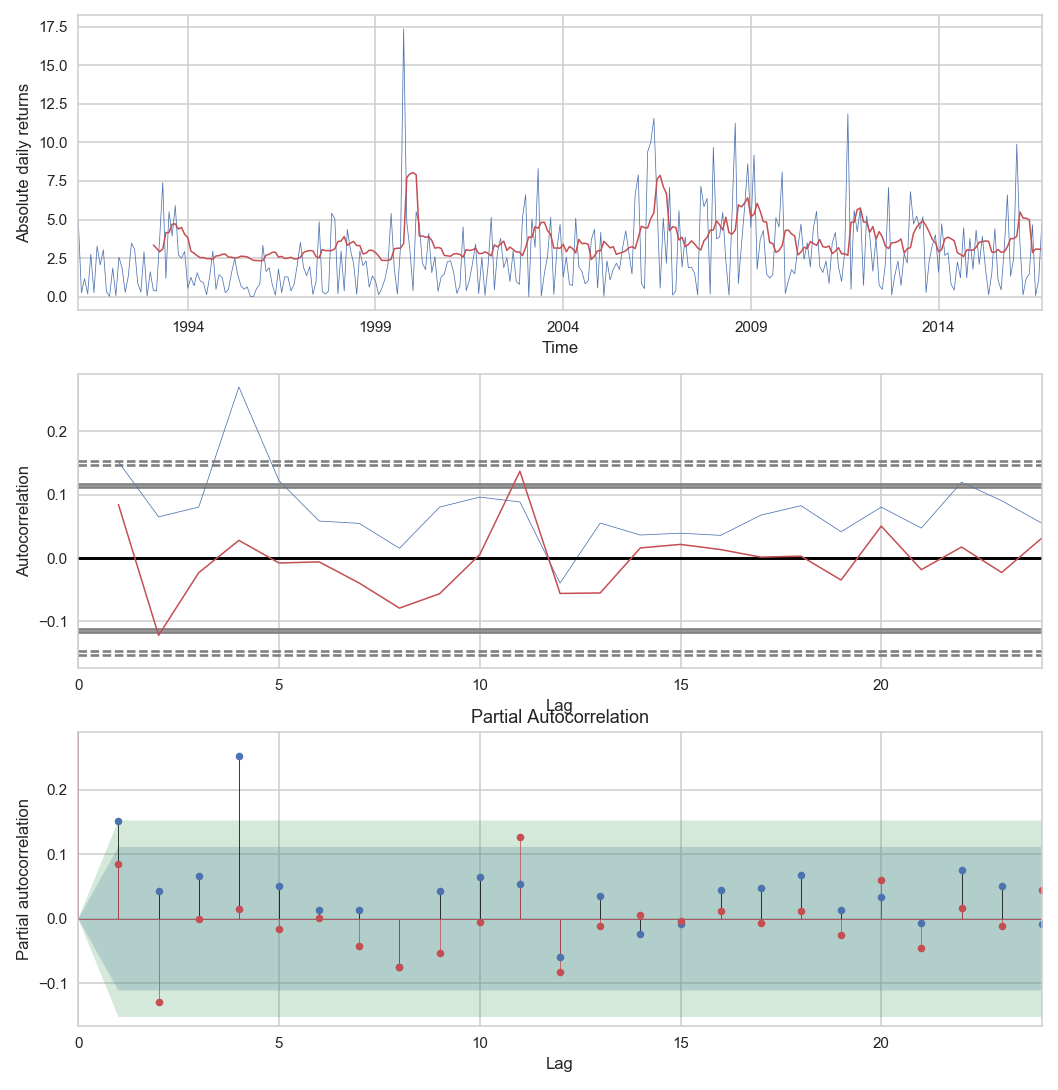

In [19]:
result.conditional_volatility.plot(linewidth=1, color='#c44e52', ax=return_ax)
autocorrelation_plot(result.resid.dropna(), linewidth=1, color='#c44e52', ax=aucorr_ax)
plot_pacf(result.resid.dropna(), lags=max_lag, alpha=0.01, ax=pacorr_ax, linewidth=0.5, color='#c44e52')

### Let's try a forecast  on the returns ...

<IPython.core.display.Javascript object>


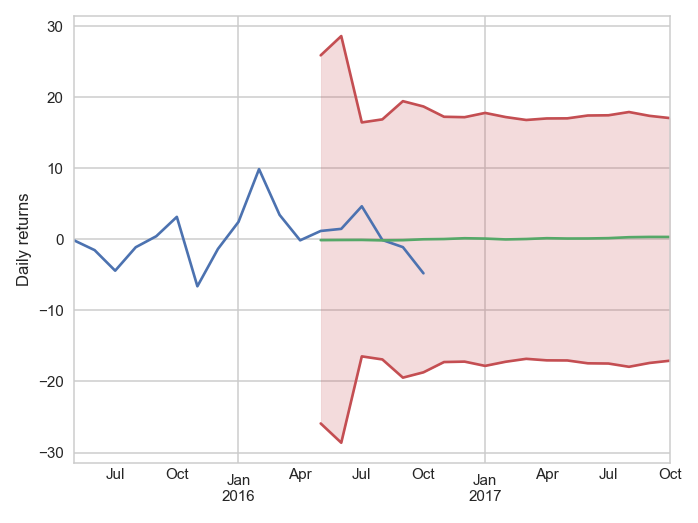

In [20]:
n_sims = 1000 # Number of simulations to average over
future = 12   # Number of future business months to provide a forecast for
past = 6      # Number of business months in the past to start our the forecast at

start_d = returns.index[-past-1]
horizon = past + future

forecast = result.forecast(horizon=horizon, 
                           start=start_d, 
                           align='origin', 
                           method='simulation', 
                           simulations=n_sims)

fc_index = pd.DatetimeIndex(freq='BM', start=start_d + pd.tseries.offsets.BMonthEnd(1), periods=horizon)
fc_frame = pd.DataFrame(data=forecast.mean.iloc[-past-1:].values[0], index=fc_index, columns=['mean'])
fc_frame['+var'] =  forecast.variance.iloc[-past-1:].values[0]
fc_frame['-var'] = -forecast.variance.iloc[-past-1:].values[0]

fig, ax = plt.subplots(num='Forecast on Returns of '+name)

returns.iloc[-horizon:].plot(ax=ax)
fc_frame['mean'].plot(ax=ax)
fc_frame['+var'].plot(ax=ax, color='#c44e52')
fc_frame['-var'].plot(ax=ax, color='#c44e52')
ax.fill_between(fc_index, fc_frame['+var'], fc_frame['-var'], color='#c44e52', alpha=0.2)
ax.set_ylabel('Daily returns')

fig.tight_layout()

### ... and on the actual index

<IPython.core.display.Javascript object>


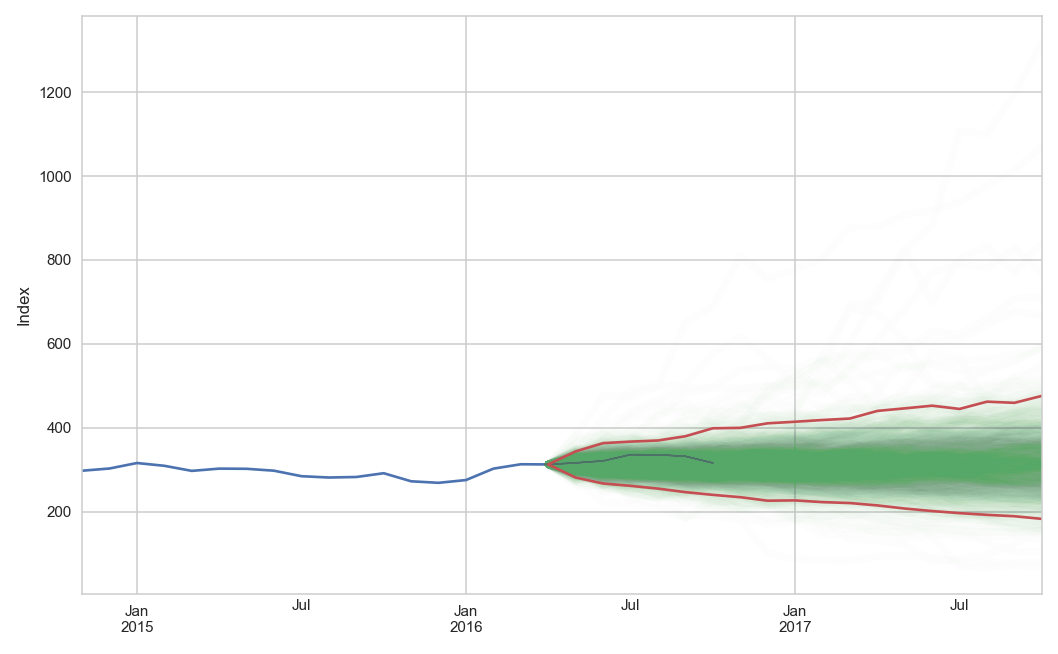

In [21]:
past_pad = max_lag # Number of business months in the past to include into the plot

fig, ax = plt.subplots(num='Forecast on Index of '+name, figsize=(9.7, 6))
data.iloc[-past_pad:].plot(ax=ax)

init_val = data[-past-1]
fc_frame = pd.DataFrame(data=np.zeros((horizon, n_sims)), index=fc_index)
fc_frame.loc[start_d] = init_val
fc_frame.sort_index(inplace=True)
for sim in range(n_sims):
    fc_frame.loc[1:, sim] = init_val * (forecast.simulations.values[-past-1][sim] / 100 + 1).cumprod()
    fc_frame[sim].plot(ax=ax, color='#55a868', alpha=0.01, linewidth=5)

confintvls = [fc_frame.iloc[0, :2].tolist()]
for day in range(1, horizon+1):
    confintvls.append(np.percentile(fc_frame.iloc[day], (2.5, 97.5)).tolist())
ci_frame = pd.DataFrame(confintvls, index=fc_frame.index)
ci_frame.plot(ax=ax, color='#c44e52', legend=False)

ax.set_ylabel('Time')
ax.set_ylabel('Index')
fig.tight_layout()

### Simulate the process to  see if it could make sense

<IPython.core.display.Javascript object>


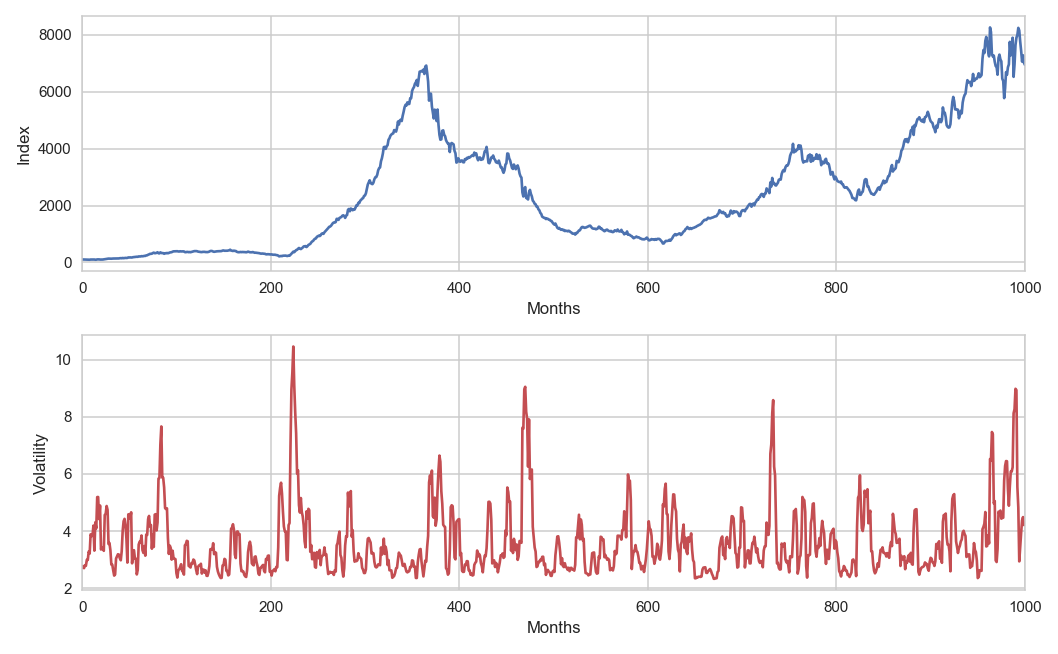

In [22]:
max_months = 1000 # Number of business months to run the simulation for
init_val = 100.   # Value that simulated index starts from

initial_vals = returns[-max(har.lags)]
initial_vola = result.conditional_volatility[-max(harch.lags)]
                        
sim_returns = model.simulate(result.params, 
                             max_months,
                             burn=1000,
                             initial_value=initial_vals, 
                             initial_value_vol=initial_vola)

sim_trace = [init_val]
sim_trace.extend(init_val * (sim_returns.data / 100 + 1).cumprod())
    
fig = plt.figure(num='Simulated Traces for the '+name+' Index and its Volatility', figsize=(9.7, 6))
vals_ax = fig.add_subplot(211)
vola_ax = fig.add_subplot(212)

vals_ax.plot(sim_trace)
vals_ax.set_xlabel('Months')
vals_ax.set_ylabel('Index')
vals_ax.set_xlim(left=0, right=max_months)

sim_returns.volatility.plot(ax=vola_ax, color='#c44e52')
vola_ax.set_xlabel('Months')
vola_ax.set_ylabel('Volatility')
vola_ax.set_xlim(left=0, right=max_months)

fig.tight_layout()